# Final Notebook of Group Pixel Patrol

## Importing the libraries used in the notebook

The following libraries are essential for importing the data, formatting it to fit into a tensorflow model and to run and evaluate the model:

- os - For interacting with the operating system.
- numpy (np) - For numerical operations and handling arrays.
- tensorflow (tf) - For deep learning tasks.
- tensorflow.keras.preprocessing.image (ImageDataGenerator) - For image preprocessing.
- tensorflow.keras (layers, models) - For building neural networks.
- sklearn.metrics (classification_report, confusion_matrix) - For evaluating classification models.
- matplotlib.pyplot (plt) - For plotting graphs.
- ipywidgets (widgets) - For creating interactive widgets in Jupyter Notebooks.
- Python.display (display) - For displaying content in Jupyter Notebooks.
- tensorflow.keras.preprocessing.image (image) - For loading and preprocessing images.
- PIL (Image) - For image processing.
- io - For handling input/output operations.
- datetime (datetime) - For working with date and time.
- tensorflow.keras.callbacks (EarlyStopping) - For controlling the training process.
- pandas (pd) - For data manipulation and analysis.

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from tensorflow.keras.preprocessing import image
from PIL import Image
import io
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

## Defining the paths to the dataset

The next code chung sets up paths to different data directories (train, valid, test) using os.path.join(), ensuring the correct formation of file paths. The base_dir points to a folder that contains subdirectories for training, validation, and testing data, which are necessary for the subsequent model training and evaluation.

Additionally, the Path class from the pathlib library provides a cleaner, platform-independent way to handle file paths. It simplifies path manipulation using the / operator, makes file and directory operations easier, and improves code readability by offering intuitive methods like checking if a path exists, getting parent directories, and more.

In [6]:
# Pay attemtion to the path 
base_dir = '../real_vs_fake/real-vs-fake'
#|--project
#|-----TechLabs-DL-2024
#|----------model.ipynb
#|----------README.md
#|-----real-vs-fake
#|----------test
#|----------train
#|----------valid

train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

## Setting Parameters, Preprocessing and data generators

### Setting Parameters

The code begins by defining two key parameters:

- batch_size = 20 sets the number of images that will be processed at a time during training, validation, or testing.
- img_size = (150,150) resizes each image to 150x150 pixels before being input into the model, ensuring uniformity across the dataset.

### Data Preprocessing

The ImageDataGenerator(rescale=1./255) function is used to normalize the pixel values of all images by scaling them between 0 and 1. This is done by dividing each pixel value by 255. Normalization helps the model train more effectively by standardizing the input data.

### Training Data Generator

The train_generator is responsible for loading images from the train_dir, resizing them to img_size, and processing batches of 20 images at a time. It performs binary classification by categorizing the images as either ‘real’ or ‘fake’. The images are shuffled to introduce randomness into the training process, which helps prevent the model from overfitting to the data. A seed (seed=42) is set to ensure reproducibility of the shuffling across runs.

### Validation Data Generator

The valid_generator works similarly to the training data generator but loads data from the valid_dir for validation. The same image size, batch size, and binary classification process are applied. Like the training data, the validation data is also shuffled to introduce randomness during the validation process.

### Test Data Generator

The test_generator loads test data from the test_dir and prepares it for evaluation after the model is trained. However, unlike the training and validation generators, the test data is not shuffled (shuffle=False). This ensures that the model evaluates the images in a consistent order, making it easier to assess its final performance.

These data generators automate the loading, normalization, and batching of images, simplifying the process of working with large datasets in machine learning projects.

In [7]:
batch_size = 20
img_size = (150,150)

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['real', 'fake'],
    shuffle=True,
    subset=None,
    seed=42
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['real', 'fake'],
    shuffle=True,
    subset=None,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['real', 'fake'],
    shuffle=False
)


Found 102041 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


## Loading pre-trained model

The code initializes the InceptionV3 model from TensorFlow’s Keras applications. Here’s what each part does:

- weights='imagenet': This parameter loads the model with pre-trained weights from the ImageNet dataset. This allows the model to start with features learned from a large and diverse image dataset, which can be helpful for transferring knowledge to new tasks.
- include_top=False: By setting this to False, the model excludes the top fully connected layers that are typically used for classification in the original InceptionV3 model. This is useful when you’re using the model as a feature extractor and want to add your own custom layers on top.
- input_shape=(150, 150, 3): This specifies the shape of the input images. Each image is resized to 150x150 pixels and has 3 color channels (RGB).

In [4]:
# Load InceptionV3
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet', 
    include_top=False,  # We don't need the top layer (fully connected layer)
    input_shape=(150, 150, 3)  # Input shape of our images
)

## Making the pre-trained model trainable

The code chung below is used to set all layers of the base_model to be trainable. Here’s what this does:

- for layer in base_model.layers: This loop iterates through each layer in the base_model, which in this case is the InceptionV3 model.
- layer.trainable = True: This line sets each layer’s trainable attribute to True, meaning that during training, the weights of these layers will be updated based on the training data.

By default, pre-trained models like InceptionV3 may have their layers set to non-trainable if you only want to use them for feature extraction. Setting layer.trainable = True ensures that the model’s weights are adjusted during training, allowing you to fine-tune the model for your specific task or dataset.

In [5]:
for layer in base_model.layers:
    layer.trainable = True

## Adding Custom Layers and Compiling the Model

In this section, custom layers are added on top of the pre-trained base model (InceptionV3), and the model is then compiled.

1.	Custom Layers:
- base_model: This is the pre-trained InceptionV3 model that extracts features from images.
- GlobalAveragePooling2D: This layer simplifies the data by averaging feature maps, making it easier for the next layers.
- Dense(512, activation='relu'): Fully connected layers with 512 units and ReLU activation learn and refine features.
- Dropout(0.5): This helps prevent overfitting by randomly dropping 50% of the neurons during training.
- Dense(1, activation='sigmoid'): The final layer outputs a probability for binary classification (e.g., ‘real’ or ‘fake’).
2. Compiling the Model:
- Optimizer: Adam with a learning rate of 0.001 updates the model weights during training.
- Loss Function: Binary cross-entropy measures how well the model’s predictions match the actual labels.
- Metric: Accuracy shows how often the model’s predictions are correct.


In [6]:
# Add custom layers on top of the base model
model = models.Sequential([
    base_model,  # Add the base model as the first layer
    layers.GlobalAveragePooling2D(),  # Reduces dimensions without further convolutions
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Adding callbacks

Early stopping is used to prevent overfitting and ensure the best model is saved during training:

- monitor='val_loss': Watches the validation loss to track the model’s performance on unseen data.
- mode='min': Stops training when the validation loss no longer decreases, aiming to minimize it.
- patience=3: If there’s no improvement in validation loss for 3 consecutive epochs, training will stop.
- restore_best_weights=True: Ensures that the model’s weights are reverted to the best state observed during training.

This setup helps to automatically stop training when the model starts to overfit and keeps the best version of the model.

In [7]:
# adding early stopping to not miss best model

early_stopping = EarlyStopping(
    monitor='val_loss',     # Continiously validation loss
    mode='min',             # Stops when val_loss is minimized
    patience=3,             # Waits 3 epochs id no improvement
    restore_best_weights=True  # Restores best model weights when training stops
)

## Training the model

The code trains the model with the following setup:

- train_generator: Provides batches of training images.
- steps_per_epoch: Defines how many batches are processed in each epoch, calculated by dividing the total number of training samples by the batch size.
- ****epochs=100**: Sets the maximum number of training epochs. Early stopping will ensure that training stops early if there’s no improvement.
- validation_data=valid_generator: Uses the validation data to evaluate the model’s performance after each epoch.
- validation_steps: Specifies the number of validation batches to process, similar to steps_per_epoch.
- callbacks=[early_stopping]: Uses the EarlyStopping callback to halt training when there’s no improvement in validation loss, ensuring the best model is saved.

This configuration allows the model to train efficiently while monitoring for overfitting and adjusting training duration automatically.

In [8]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # number of batches per epoch
    epochs=100,  # high number of epochs is ok due to early stopping
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    callbacks=[early_stopping]   # EarlyStopping callback 
)

Epoch 1/100


2024-09-05 20:41:40.759261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-09-05 20:41:40.762273: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


5102/5102 [==============================] - ETA: 0s - loss: 0.2774 - accuracy: 0.8832

2024-09-05 21:39:11.782081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5102/5102 [==============================] - 3624s 710ms/step - loss: 0.2774 - accuracy: 0.8832 - val_loss: 0.1656 - val_accuracy: 0.9347
Epoch 2/100
5102/5102 [==============================] - 3647s 715ms/step - loss: 0.1086 - accuracy: 0.9600 - val_loss: 0.0777 - val_accuracy: 0.9707
Epoch 3/100
5102/5102 [==============================] - 3516s 689ms/step - loss: 0.0743 - accuracy: 0.9715 - val_loss: 1.3747 - val_accuracy: 0.9636
Epoch 4/100
5102/5102 [==============================] - 3512s 688ms/step - loss: 0.0617 - accuracy: 0.9764 - val_loss: 0.0611 - val_accuracy: 0.9779
Epoch 5/100
5102/5102 [==============================] - 3502s 686ms/step - loss: 0.0541 - accuracy: 0.9788 - val_loss: 0.1460 - val_accuracy: 0.9657
Epoch 6/100
5102/5102 [==============================] - 3502s 686ms/step - loss: 0.0440 - accuracy: 0.9827 - val_loss: 0.0771 - val_accuracy: 0.9849
Epoch 7/100
5102/5102 [==============================] - 3504s 687ms/step - loss: 0.0373 - accuracy: 0.9845 - va

## Evaluating the model

The code performs evaluation on both the test and validation sets with the following steps:

- Evaluate on the Test Set:
- model.evaluate(test_generator): Computes the loss and accuracy on the test data.
- print(f"Test Accuracy: {test_acc:.2f}"): Displays the accuracy of the model on the test set.
- model.predict(test_generator): Predicts the labels for the test images.
- np.round(Y_pred_test).astype(int): Rounds the predictions to the nearest integer (0 or 1).
- confusion_matrix(test_generator.classes, y_pred_test): Displays the confusion matrix, showing true vs. predicted classifications.
- classification_report(test_generator.classes, y_pred_test, target_names=['Real', 'Fake']): Prints a detailed classification report with precision, recall, and F1-score for each class.
- Evaluate on the Validation Set:
- model.evaluate(valid_generator): Computes the loss and accuracy on the validation data.
- print(f"Validation Accuracy: {val_acc:.2f}"): Displays the accuracy of the model on the validation set.
- model.predict(valid_generator): Predicts the labels for the validation images.
- np.round(Y_pred_val).astype(int): Rounds the predictions to the nearest integer.
- confusion_matrix(valid_generator.classes, y_pred_val): Displays the confusion matrix for the validation set.
- classification_report(valid_generator.classes, y_pred_val, target_names=['Real', 'Fake']): Prints the classification report for the validation set.

This evaluation helps assess the model’s performance on unseen test and validation data, providing insights into accuracy and detailed metrics.


In [9]:
# Evaluate on the Test Set
print("Evaluating on Test Set:")
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Accuracy: {test_acc:.2f}")

Y_pred_test = model.predict(test_generator)
y_pred_test = np.round(Y_pred_test).astype(int)

print('Confusion Matrix - Test Set')
print(confusion_matrix(test_generator.classes, y_pred_test))

print('Classification Report - Test Set')
print(classification_report(test_generator.classes, y_pred_test, target_names=['Real', 'Fake']))

# Evaluate on the Validation Set
print("\nEvaluating on Validation Set:")
val_loss, val_acc = model.evaluate(valid_generator, steps=valid_generator.samples // valid_generator.batch_size)
print(f"Validation Accuracy: {val_acc:.2f}")

Y_pred_val = model.predict(valid_generator)
y_pred_val = np.round(Y_pred_val).astype(int)

print('Confusion Matrix - Validation Set')
print(confusion_matrix(valid_generator.classes, y_pred_val))

print('Classification Report - Validation Set')
print(classification_report(valid_generator.classes, y_pred_val, target_names=['Real', 'Fake']))

Evaluating on Test Set:


2024-09-06 03:35:07.857827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1000/1000 [==============================] - 174s 174ms/step - loss: 0.0647 - accuracy: 0.9773
Test Accuracy: 0.98


2024-09-06 03:38:02.128147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1000/1000 [==============================] - 174s 174ms/step
Confusion Matrix - Test Set
[[9793  207]
 [ 246 9754]]
Classification Report - Test Set
              precision    recall  f1-score   support

        Real       0.98      0.98      0.98     10000
        Fake       0.98      0.98      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000


Evaluating on Validation Set:
   1/1000 [..............................] - ETA: 3:00 - loss: 0.0143 - accuracy: 1.0000

2024-09-06 03:40:56.590096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1000/1000 [==============================] - 174s 174ms/step - loss: 0.0611 - accuracy: 0.9779
Validation Accuracy: 0.98
   1/1000 [..............................] - ETA: 3:19

2024-09-06 03:43:50.391365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1000/1000 [==============================] - 174s 174ms/step
Confusion Matrix - Validation Set
[[4987 5013]
 [5035 4965]]
Classification Report - Validation Set
              precision    recall  f1-score   support

        Real       0.50      0.50      0.50     10000
        Fake       0.50      0.50      0.50     10000

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



## Saving the model

The following code saves the model on drive

In [10]:
model.save('pretrained_trainable_version2.h5')  # HDF5 format

## Plotting performance

The following code plots the models performance.

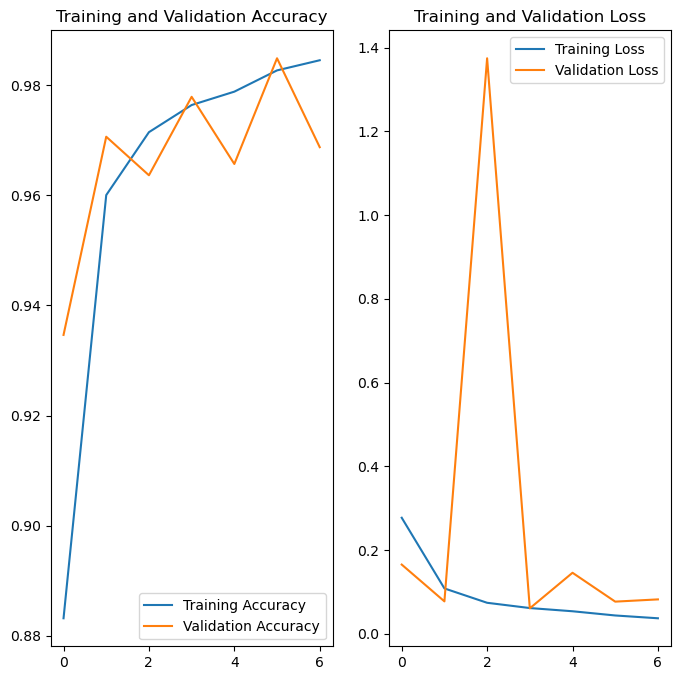

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(7)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Export history

The following code exports model history and performance ans pandas dataframe and saves it to csv

In [15]:
history_df = pd.DataFrame(history.history)

In [16]:
history_df

,loss,accuracy,val_loss,val_accuracy
0,0.277406,0.883181,0.165561,0.93465
1,0.108603,0.960047,0.077681,0.97065
2,0.074325,0.971476,1.374691,0.96365
3,0.061739,0.976407,0.061111,0.97790
4,0.054089,0.978838,0.146000,0.96570
5,0.044013,0.982700,0.077076,0.98490
6,0.037317,0.984542,0.082415,0.96875


In [19]:
# lets add model history to CSV so that we can make a cool graph out of it later
# Pls change layer name :)
history_df.to_csv("trainable_google_layer_model_history.csv", index = True)